In [ ]:
!pip install langchain
!pip install streamlit
!pip install PyPDF2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 987.7/987.7 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 372.0/372.0 kB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.0/135.0 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.1/141.1 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 21.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 65.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 755.4 kB/s eta 0:00:00


In [ ]:
import streamlit as st
from PyPDF2 import PdfReader
!pip install -U langchain-community
from langchain.embeddings import OpenAIEmbeddings, SentenceTransformerEmbeddings
from langchain.chat_models import ChatOpenAI
from langchain.chains import ConversationalRetrievalChain, RetrievalQA
from langchain.memory import ConversationBufferWindowMemory
from langchain.vectorstores import FAISS
from langchain.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.2/49.2 kB 1.5 MB/s eta 0:00:00


In [ ]:
#PDF 문서에서 텍스트를 추출
def get_pdf_text(pdf_docs):
    text = ""
    for pdf in pdf_docs:
        pdf_reader = PdfReader(pdf)
        for page in pdf_reader.pages:
            text += page.extract_text()
    return text

#chunk로 분할
def get_text_chunks(text):
    text_splitter = RecursiveCharacterTextSplitter(
        separators="\\n",
        chunk_size=1000,
        chunk_overlap=200,
        length_function=len
    )
    chunks = text_splitter.split_text(text)
    return chunks

#vectorization
def get_vectorstore(text_chunks):
    embeddings = SentenceTransformerEmbeddings(model_name='all-MiniLM-L6-v2')
    vectorstore = FAISS.from_texts(texts=text_chunks, embedding=embeddings)
    return vectorstore

In [ ]:
import os
os.environ["OPENAI_API_KEY"] = ""

def get_conversation_chain(vectorstore):
    memory = ConversationBufferWindowMemory(memory_key='chat_history', return_message=True)  #ConversationBufferWindowMemory에 이전 대화 저장
    conversation_chain = ConversationalRetrievalChain.from_llm(
        llm=ChatOpenAI(temperature=0, model_name='gpt-3.5-turbo-16k-0613'),
        retriever=vectorstore.as_retriever(),
        get_chat_history=lambda h: h,
        memory=memory
    ) #ConversationalRetrievalChain을 통해 langchain 챗봇에 쿼리 전송
    return conversation_chain

In [ ]:
user_uploads = st.file_uploader("파일을 업로드해주세요.", accept_multiple_files=True)
if user_uploads is not None:
    if st.button("Upload"):
        with st.spinner("processing.."):
            # PDF 텍스트 가져오기
            raw_text = get_pdf_text(user_uploads)
            # 텍스트에서 청크 검색
            text_chunks = get_text_chunks(raw_text)
            # PDF 텍스트 저장을 위해 FAISS 벡터 저장소 만들기
            vectorstore = get_vectorstore(text_chunks)
            # 대화 체인 만들기
            st.session_state.conversation = get_conversation_chain(vectorstore)

2024-07-19 04:20:27.483 
  command:

    streamlit run /usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py [ARGUMENTS]


## UI setting

In [ ]:
if user_query := st.chat_input("질문을 입력해주세요~"):
    # 대화 체인을 사용하여 사용자의 메시지를 처리
    if 'conversation' in st.session_state:
        result = st.session_state.conversation({
            "question": user_query,
            "chat_history": st.session_state.get('chat_history', [])
        })
        response = result["answer"]
    else:
        response = "먼저 문서를 업로드해주세요~."
    with st.chat_message("assistant"):
        st.write(response)

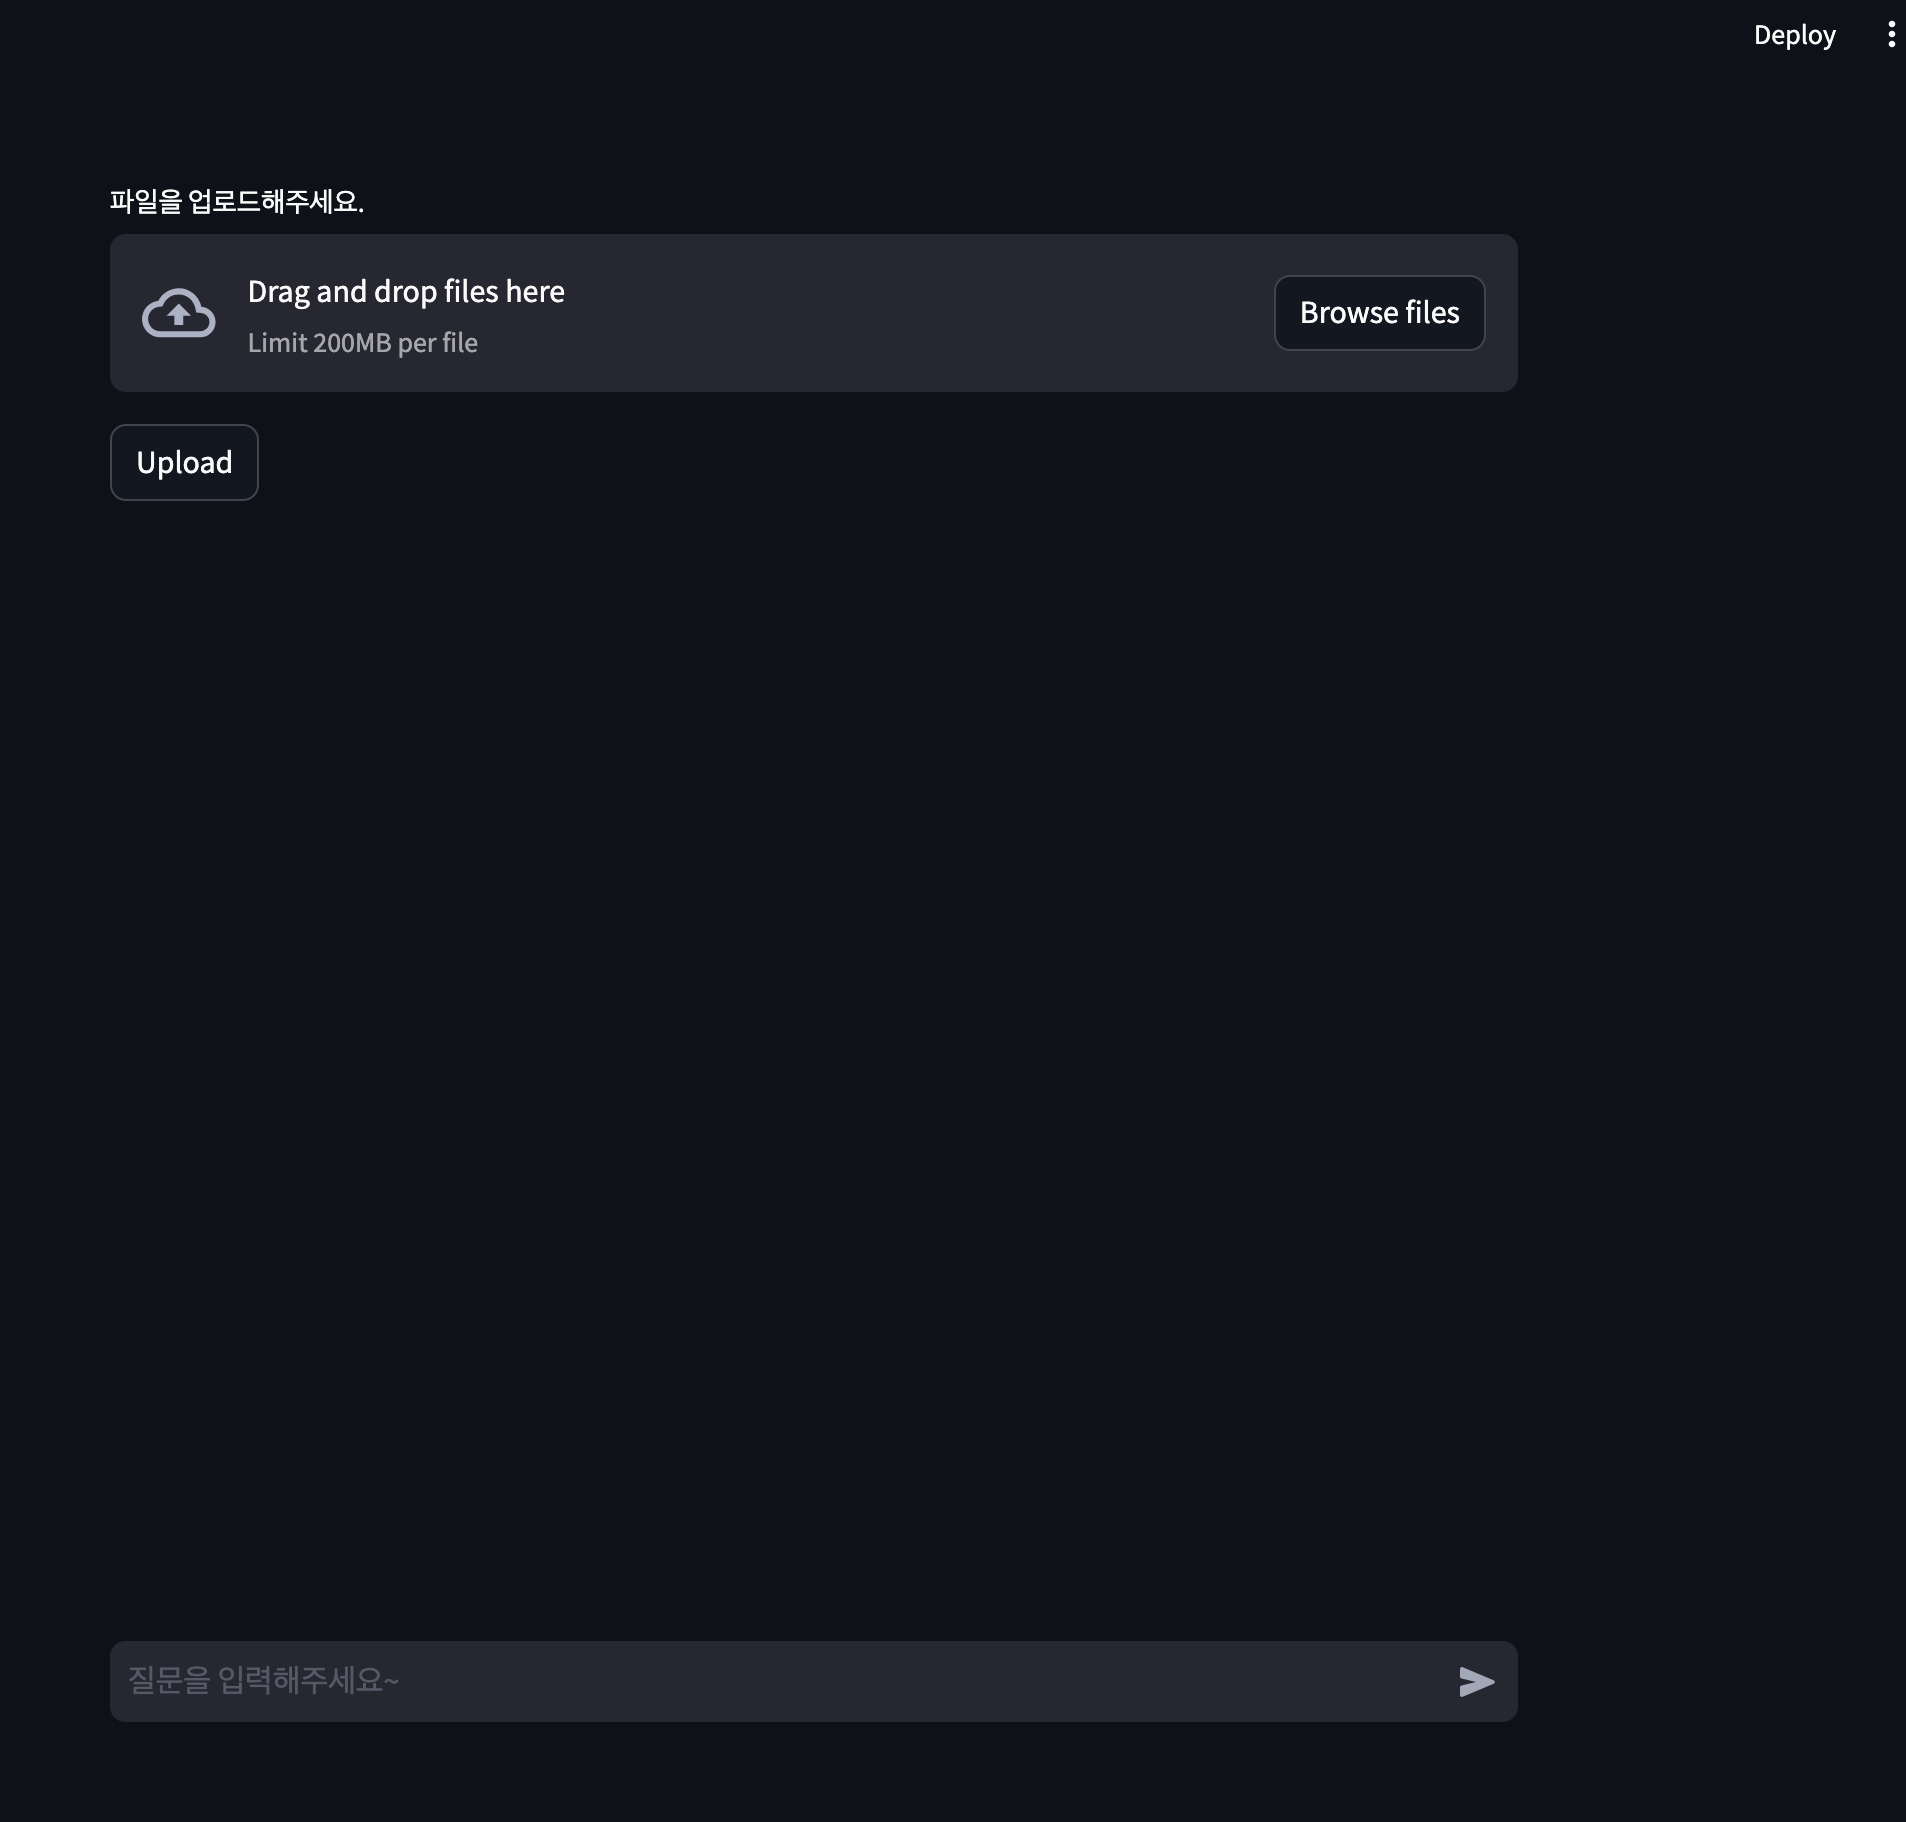





**굵은 텍스트**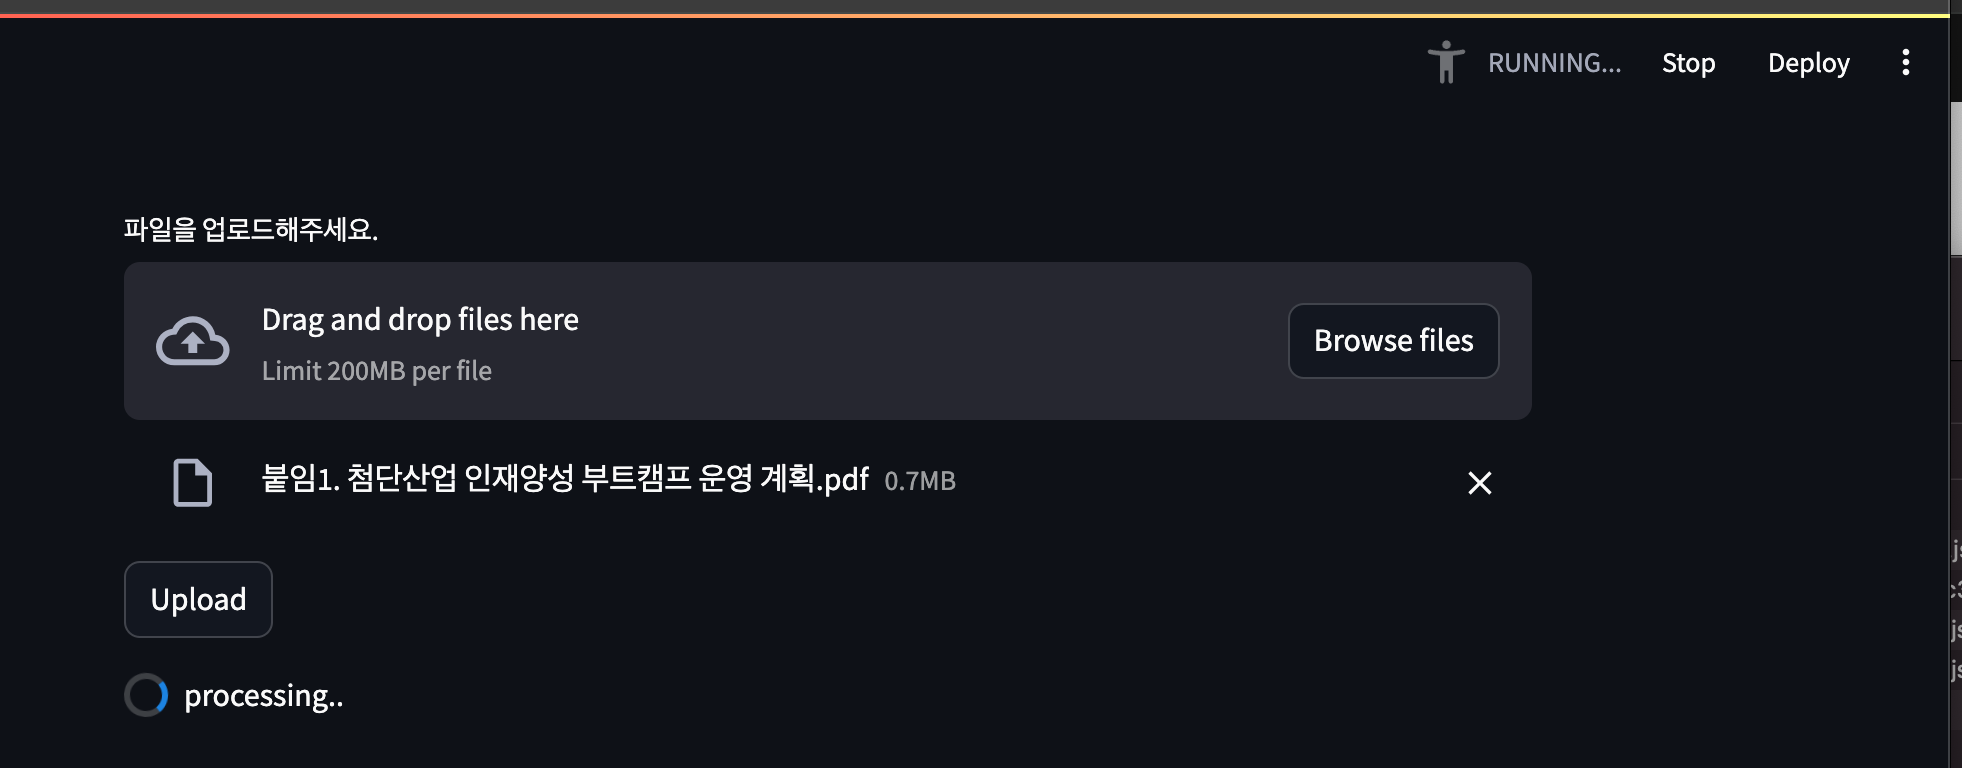





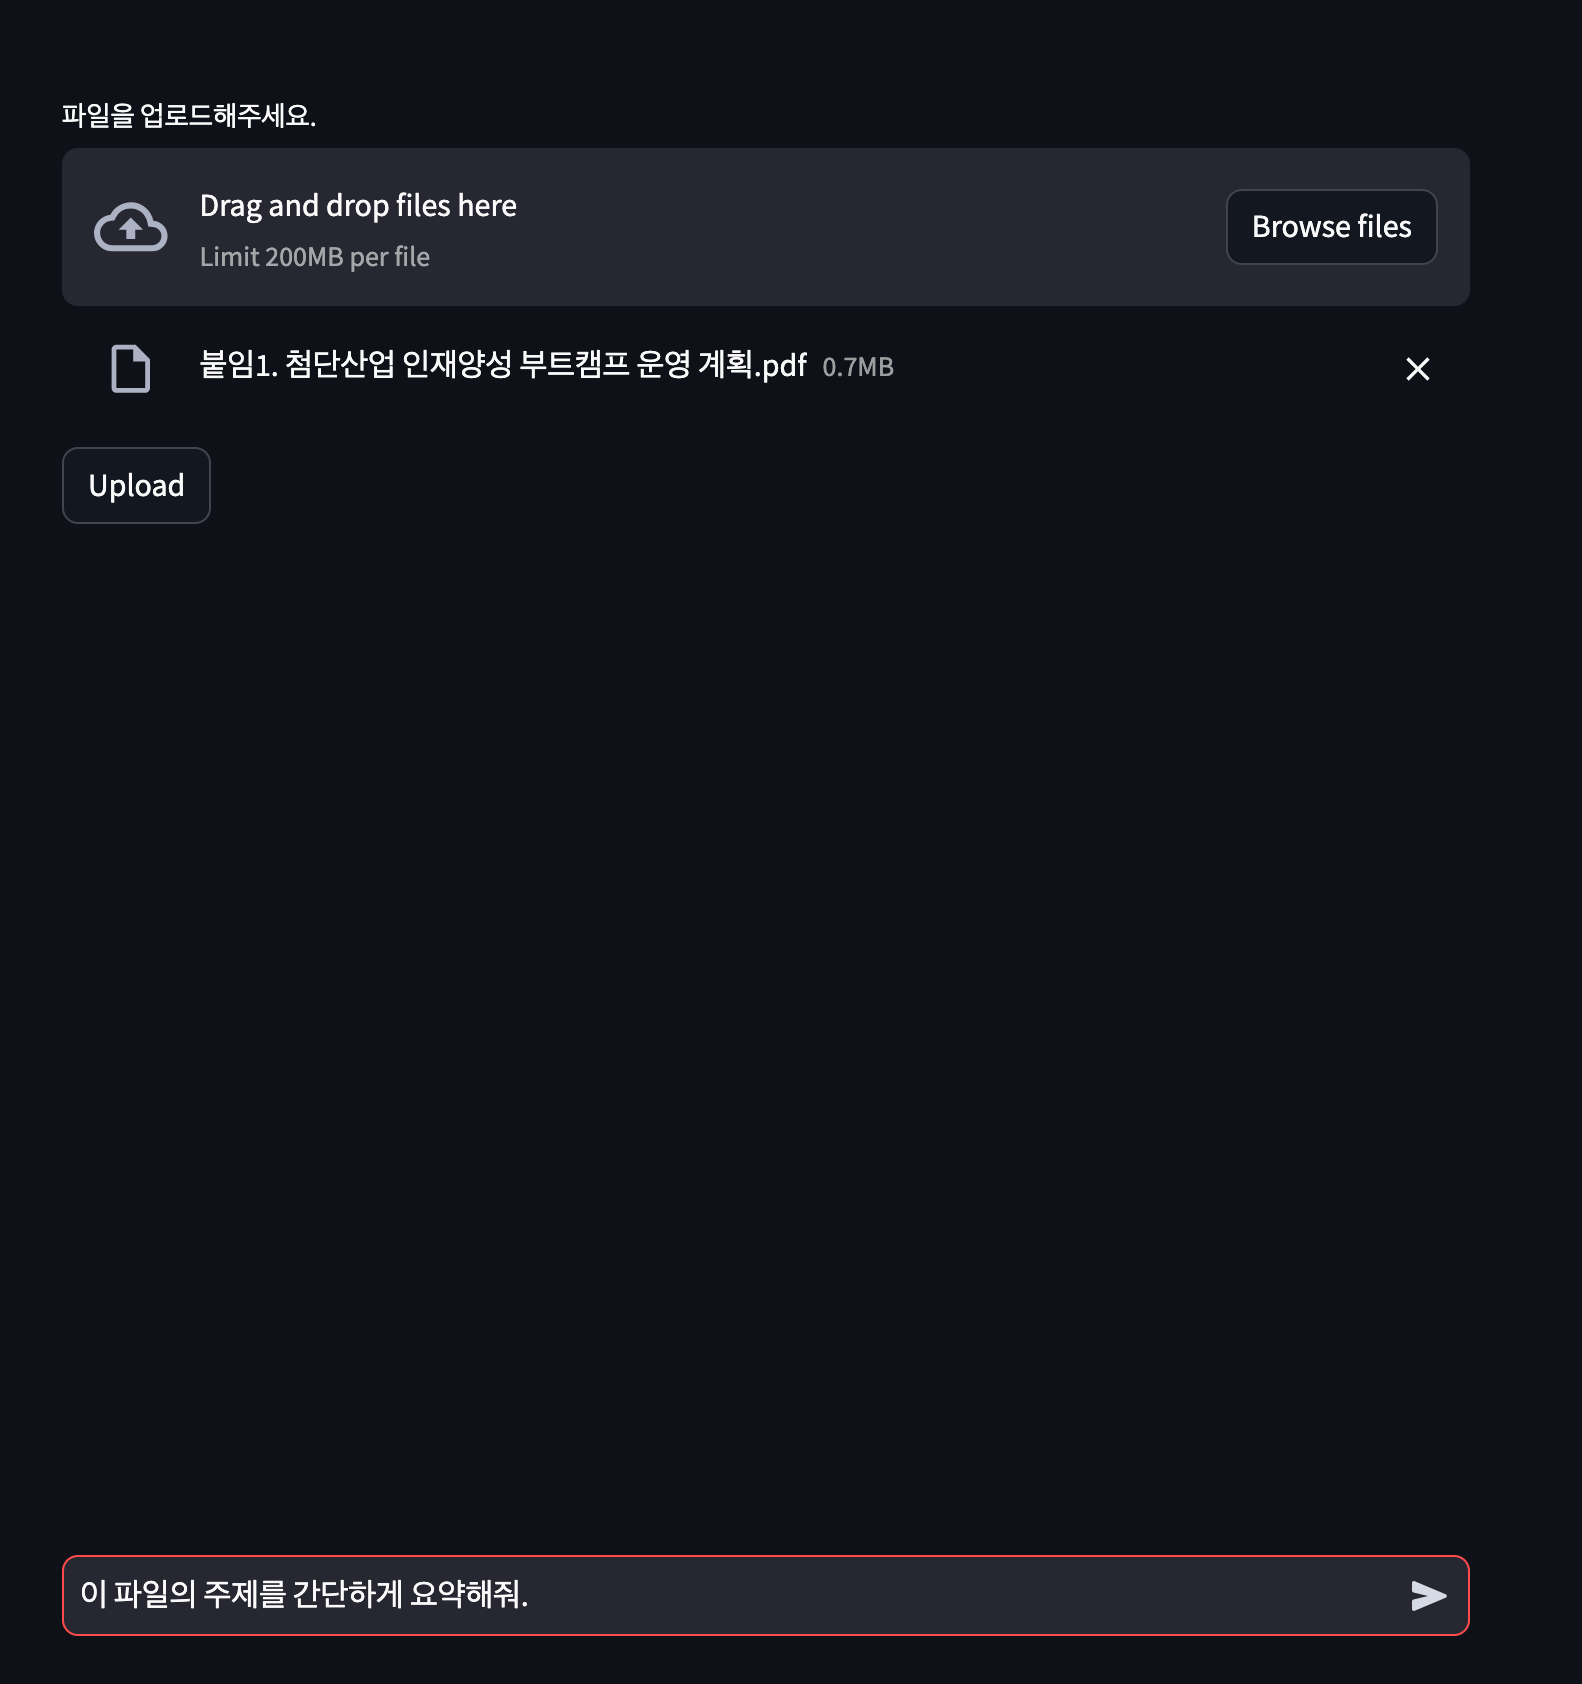